<a href="https://colab.research.google.com/github/mindyng/Projects/blob/master/Knowledge_Graph_Hello_World.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First steps into Knowledge Graph embedding models in PyKeen.

[Original](https://github.com/pykeen/pykeen/blob/master/notebooks/hello_world/Hello%20World!.ipynb)

From this notebook, will be able to complete the following:

1. Train a model
2. Evaluate how well it learned
3. Turn it around and start making  predictions.

#Imports

In [16]:
!pip install pykeen

In [17]:
import getpass
import os
import sys
import time

import matplotlib.pyplot as plt
import pandas as pd
import pykeen
import torch
from pykeen.pipeline import pipeline

%matplotlib inline

In [18]:
print(sys.version)

3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]


In [19]:
print(time.asctime())

Sat Jul  4 18:26:26 2020


In [20]:
print(getpass.getuser())

root


In [21]:
print(pykeen.get_version(with_git_hash=True))

1.0.1-UNHASHED


##Dataset

Before training model, let's take a quick look at the Nations dataset to get a breakdown of how dataset is split for training.

In [24]:
from pykeen.datasets import datasets, Nations

nations = Nations()
nations.summarize()

Nations (create_inverse_triples=False)
Name          Entities    Relations    Triples
----------  ----------  -----------  ---------
Training            14           55       1592
Testing             14           41        201
Validation          14           45        199


## Train a Model

More tutorials to train first model [here](https://pykeen.readthedocs.io/en/latest/first_steps.html).

Modifications to this:
1. swtich model
2. add a loss
3. add a regularizer
4. switch training assumption from sLCWA to LCWA
5. Each model does have their own hyper-parameters but PyKEEN tries to have reasonable defaults. Most useful hyperparameter to change is num_epochs in training_kwargs, which is shown below.

In [22]:
result = pipeline(
    dataset = 'Nations',
    model = 'RotatE',
    training_kwargs=dict(num_epochs=100),
)

Training epochs on cpu:   0%|          | 0/100 [00:00<?, ?epoch/s]INFO:pykeen.training.training_loop:using stopper: <pykeen.stoppers.stopper.NopStopper object at 0x7fe19c7a24e0>

Training epochs on cpu: 100%|██████████| 100/100 [00:21<00:00,  4.69epoch/s, loss=0.00339, prev_loss=0.00342]
INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=201.
Evaluating on cpu: 100%|██████████| 201/201 [00:00<00:00, 10.9ktriple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.02s seconds


At this point, if on local machine: Save trained model (including triples and all learned parameters), results from training and all experimental metadata. However, since in cloud notebook, will do this another time.

## Now, let's look at the model in more detail.

In [23]:
model = result.model
model

RotatE(
  (loss): MarginRankingLoss()
  (regularizer): NoRegularizer()
  (entity_embeddings): Embedding(14, 400)
  (relation_embeddings): Embedding(55, 400)
)

## Looking at the triples (subject, predicate, object):

In [25]:
tf = model.triples_factory
tf

TriplesFactory(path="/usr/local/lib/python3.6/dist-packages/pykeen/datasets/nations/train.txt")

In [26]:
tf.num_entities, tf.num_relations, tf.num_triples

(14, 55, 1592)

## Evaluating the Results

(Check that the loss is descending and not oscillating).

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


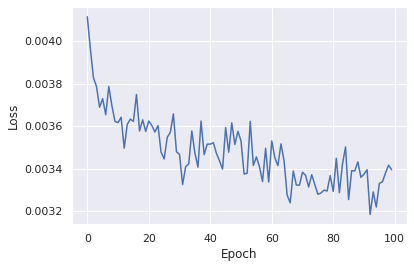

In [27]:
result.plot_losses()
plt.show()

In general, there is a downward trend, but within short windows of time there are upticks including the one at 100th epoch at the end.

Things to keep in mind:


*   adjusted mean rank is between [0,1]. Closer to 1 is best!
*   mean rank is a positive integer with a bound based on number of entities. Closer to 0 is best!
*   hits@k is reported between [0,1] and intepreted as a %. Closer to 1 is best!






In [28]:
result.metric_results.to_df()

,Type,Metric,Value
0,avg,adjusted_mean_rank,0.837563
1,best,mean_rank,3.902985
2,best,mean_reciprocal_rank,0.463393
3,best,hits_at_1,0.263682
4,best,hits_at_3,0.544776
5,best,hits_at_5,0.753731
6,best,hits_at_10,0.960199
7,worst,mean_rank,3.902985
8,worst,mean_reciprocal_rank,0.463393
9,worst,hits_at_1,0.263682


Metrics are based on loss from test set. 

Best to look at avg Type and adjusted_mean_rank metric which is only seen in avg Type. And the percentage is in the low 80's which is not bad! Remember that the dataset is small and we do have strong signal. 😊

##Now, turning it around to make predictions.

It is difficult to interpret KGEMs statistically. So it is best to sort order the predictions by their scores. All interaction functions in PyKeen have been implemented such that higher the score (less negative the score is), more likely that a triple is to be true.

And one last thing before predicting will be to create word clouds of entities and relations in the Nations dataset. Size corresponds to frequency of word appearing in triples.

In [30]:
tf.entity_word_cloud()

In [31]:
tf.relation_word_cloud()

Who do we predict Brazil to have a conference with?

In [32]:
model.predict_tails('brazil', 'conferences')

,tail_id,tail_label,score,novel
12,12,usa,-4.690113,True
11,11,uk,-4.917130,False
13,13,ussr,-4.928981,True
5,5,india,-5.255620,True
9,9,netherlands,-5.287464,False
10,10,poland,-5.472327,False
4,4,egypt,-5.476140,False
3,3,cuba,-5.560370,True
2,2,china,-5.601460,False
0,0,brazil,-5.673203,False


Now, who do we predict to have a conference with Brazil?

In [34]:
model.predict_heads('conferences', 'brazil')

,head_id,head_label,score,novel
12,12,usa,-4.826950,True
11,11,uk,-5.067481,False
5,5,india,-5.091891,True
13,13,ussr,-5.095834,True
9,9,netherlands,-5.208021,False
10,10,poland,-5.223291,True
4,4,egypt,-5.228087,False
3,3,cuba,-5.483738,True
2,2,china,-5.668639,False
0,0,brazil,-5.673203,False
